In [5]:
"""
Created By    : Jared W. Marquis
Creation Date : 01 August 2022
Course        : ATSC 528 - Atmospheric Data Analysis
Assignment    : #01 - Function Fitting

Purpose:
Script to take sparse upper air observations and analyze them on a
polar stereographic map projection using function fitting.
[PUT MORE INFORMATION HERE - I.E., WHAT SPECIFIC THING IS BEING DONE]

"""
__author__    = "Jared W. Marquis"
__contact__   = "jared.marquis@und.edu"

In [48]:
### Import Required Modules (shouldn't need to change) ###
import numpy as np                 #numpy for math
import matplotlib.pyplot as plt    #matplotlib for plotting
import cartopy.crs as ccrs         #cartopy for plotting on map
import cartopy.feature as cfeature #cartopy basic shapefiles

In [49]:
### Read in observations ###
obs = np.loadtxt('RAOBs_201903131200.txt', dtype='str', delimiter=',')

#Make the observations their own data array
obs[:,[1,2,3,4,5]].astype(float) #All obs
ID = obs[:,0] #Station ID
lat_txt = obs[:,1].astype(float) #Latitude
lon_txt = obs[:,2].astype(float) #Longitude
height = obs[:,3].astype(float) #Heights
wind_dir = obs[:,4].astype(float) #Wind Direction
wind_speed = obs[:,5].astype(float) #Wind Speed


In [50]:
#Define known variables from the HW
#These variables are either defined in our homework PDF or in our class notes
xnot = 18.9
ynot = -6.3
delx = 1.27
dely = 1.27
ro = 6371 * 1e5
lambdanot = -115
phinot = 60 * (np.pi/180)
m = 1/15000000

In [51]:
### Set up analysis map with a 22x28 rectangular grid of points ###
x_step = xnot + np.arange(22)*delx #Calculate x - grid (JUST X - 1D)
y_step = ynot + np.arange(28)*dely #Calculate y - grid (JUST Y - 1D)

#Utilize meshgrid to return coordinate matricies from coordinate vectors (produced just above this line)
gridx, gridy = np.meshgrid(x_step,y_step) #Coordinate matricies defined as gridx and gridy


In [70]:
### Perform 500mb geopotential height analyses using a second order 2-d polynomial with two ###
### radii of influence (10cm & 20cm) ###

#ROI list
RoI_arr = np.array([10,20]) #1D array of just our RoI values given on the HW


#convert lat and lon to radians
lat_rad = lat_txt * (np.pi/180)
lon_rad = lon_txt * (np.pi/180)

#Calculate sigma - equation is in our notes
sigma = ((1 + np.sin(phinot))/(1 + np.sin(lat_rad)))

#calculate lambda and convert to radians
lambda_rad = (lon_txt) * (np.pi/180)
lambdanot_rad = lambdanot * (np.pi/180)

#calculate r, x, and y on an image plane - equations are in our class notes
r = sigma * ro * np.cos(lat_rad) * m
x_plane = r * np.cos(lambda_rad - lambdanot_rad)
y_plane = r * np.sin(lambda_rad - lambdanot_rad)



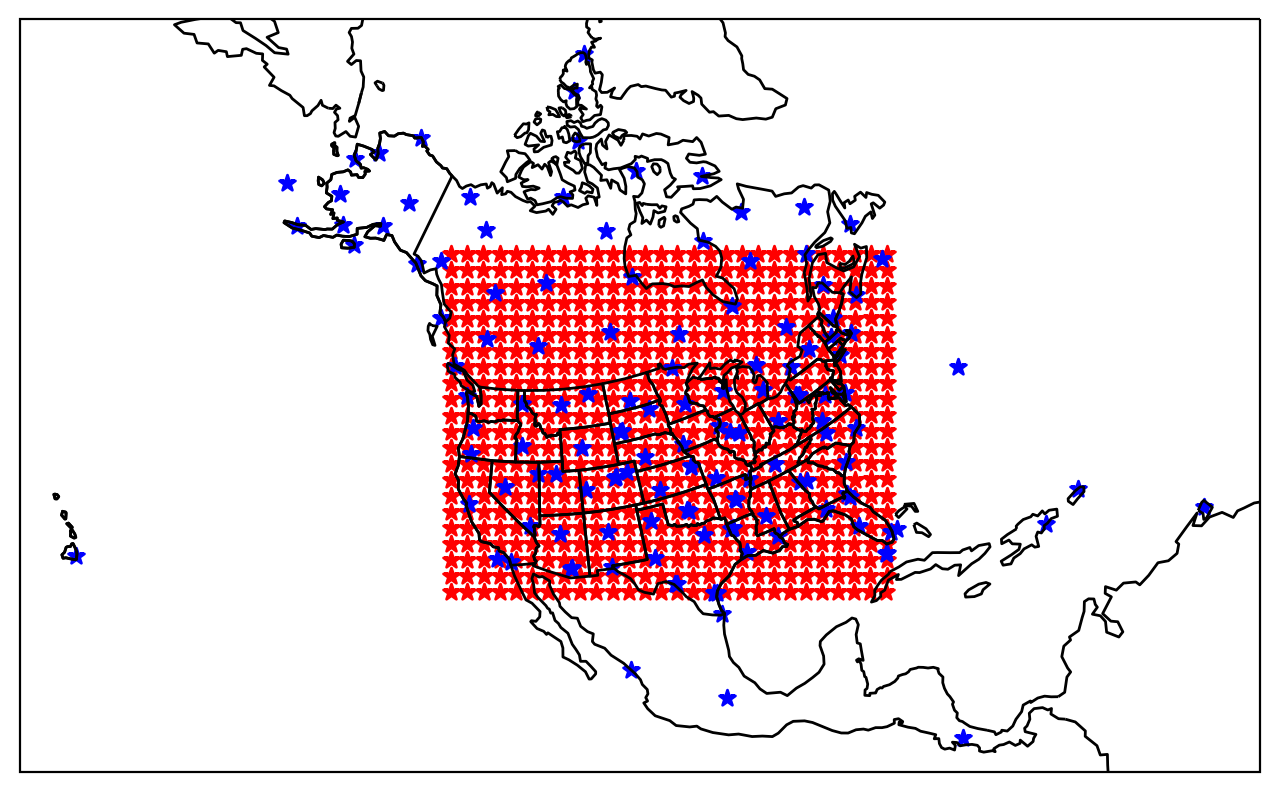

In [71]:
### convert obs lat/long to x,y (may want to plot on your analysis grid to verify)###
lon = np.arctan(gridy/gridx) * (180/np.pi) + lambdanot
lat = (180/np.pi) * ((np.pi/2) - (2 * np.arctan(((((gridx/m)**2) + (gridy/m)**2)**(1/2))/(ro * (1 + np.sin(phinot))))))

lon_ob = np.arctan(y_plane/x_plane) * (180/np.pi) + lambdanot
lat_ob = (180/np.pi) * ((np.pi/2) - (2 * np.arctan(((((x_plane/m)**2) + (y_plane/m)**2)**(1/2))/(ro * (1 + np.sin(phinot))))))


### Plot number of observations available to polynomial fitting scheme for each grid point ###
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60) #our projection
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)
ax1.scatter(lon.ravel(), lat.ravel(), c='r', marker='*', transform = ccrs.PlateCarree())
ax1.scatter(lon_ob.ravel(), lat_ob.ravel(), c='b', marker='*', transform = ccrs.PlateCarree())
plt.show()

In [81]:
#empty matrices to fill in eventually with good stuff
y_n = 22
x_n = 28
Analysis_mat = np.empty((x_n, y_n, len(RoI_arr)))
n_observations = np.empty((x_n, y_n, len(RoI_arr)))

#begin for loop
for i in range(len(RoI_arr)):
    roi = RoI_arr[i] #go through each RoI value
    for x in range(len(gridx)): #go through each x-grid point (should be 0-27 [28 total])
        for y in range(len(gridx[0])): #go through each x-grid point by in the y-dir (should be 22 total points)
            rel_x = gridx[x,y] - x_plane #relative x distance
            rel_y = gridy[x,y] - y_plane #relative y distance
            radius = (rel_x**2 + rel_y**2)**(1/2) #calculate your radius from each grid point
            index_roi = np.where(radius <= roi)[0] #calc where your radius is less than or equal to your RoI
            
            #create N_OBS matrix (empty)
            n_observations[x,y,i] = len(index_roi)
            
            #Create the Maxtrices
            X_k = rel_x[index_roi]
            Y_k = rel_y[index_roi]
            Fo = height[index_roi]
            
            #more empty arrays
            R = np.zeros((6,6))
            O = np.zeros(6)
            
            #do calc for each point inside the ROI
            for z in range(len(Y_k)):
                arr1 = np.matrix([1,X_k[z], Y_k[z], X_k[z]**2, Y_k[z]**2, X_k[z] * Y_k[z]])
                arr1_T = arr1.T
                arr2 = arr1_T * arr1
                
                #Fill in the R and O arrays
                R += np.array(arr2)
                O += np.array([Fo[z], X_k[z]*Fo[z], Y_k[z]*Fo[z], X_k[z]**2 * Fo[z], Y_k[z]**2 * Fo[z], X_k[z] * Y_k[z] * Fo[z]])
            
            #Now, div the matricies by the total number of observations
            R = R/n_observations[x,y,i]
            O = O/n_observations[x,y,i]
            
            #Now, calculate the C vector
            C = np.linalg.inv(np.matrix(R))*np.matrix(O).T
            Analysis_mat[x,y,i] = C[0,0]
            
            

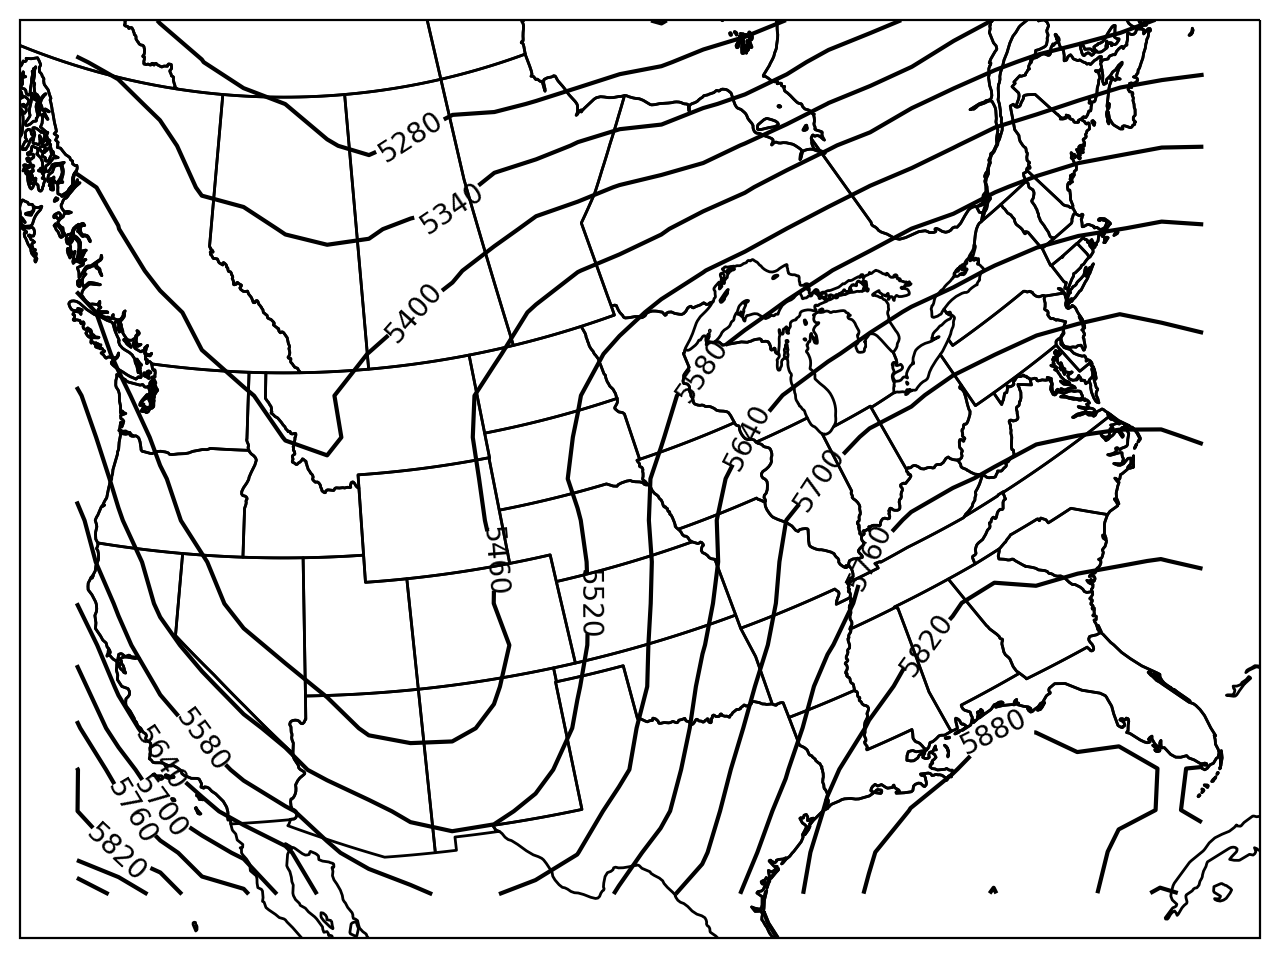

In [73]:
### Plot 500mb analyses over a map using RoI of 10 cm ###

proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(lon,lat,Analysis_mat[:,:,0],colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())

plt.clabel(cs1,levels=np.arange(0,8000,60)) #Contour levels and intervals

#show plot
plt.show()


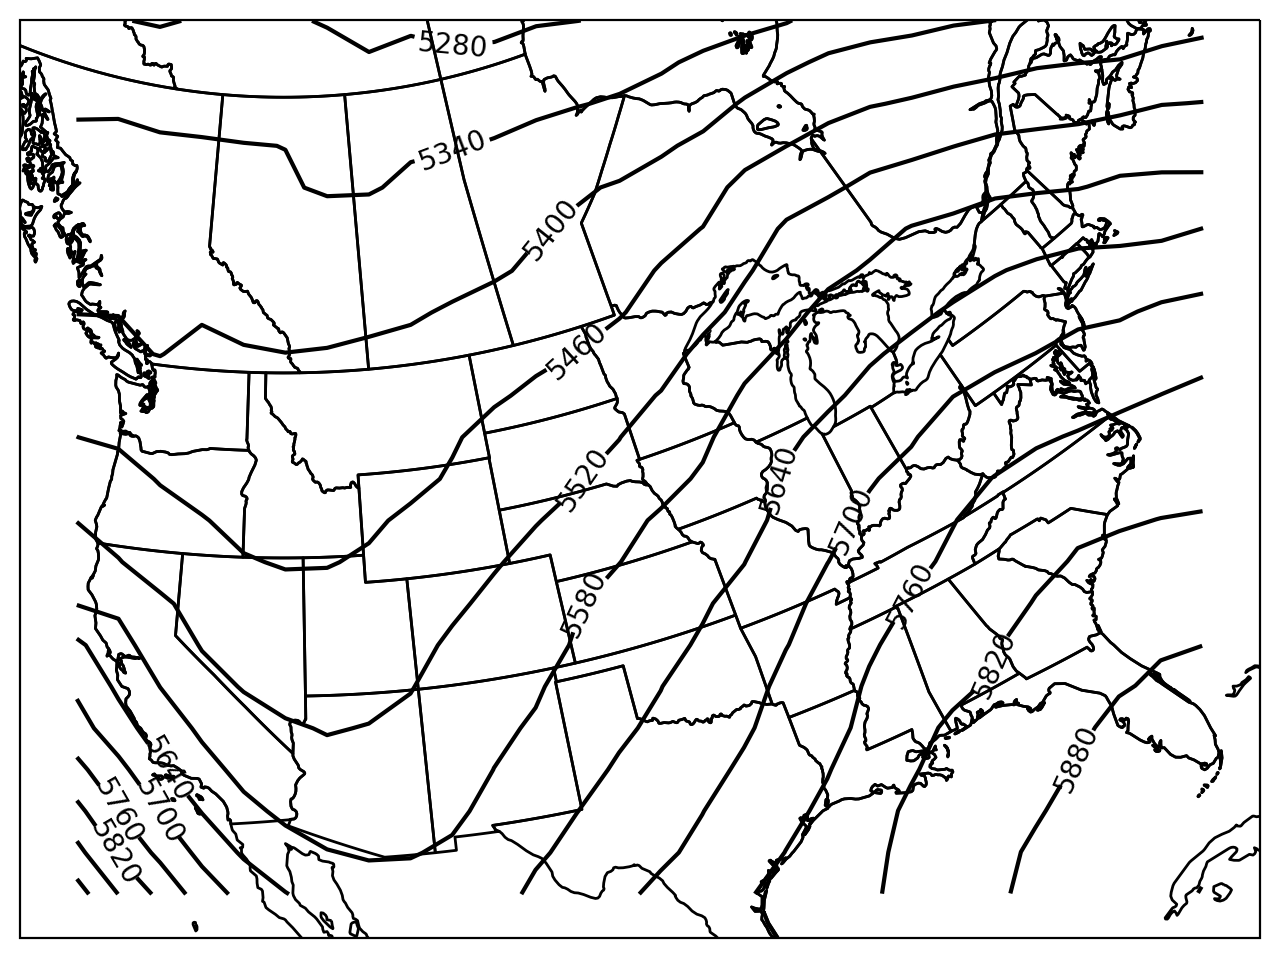

In [42]:
### Plot 500mb analyses over a map using RoI of 20 cm ###
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(lon,lat,Analysis_mat[:,:,1],colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())

plt.clabel(cs1,levels=np.arange(0,8000,60))


plt.show()

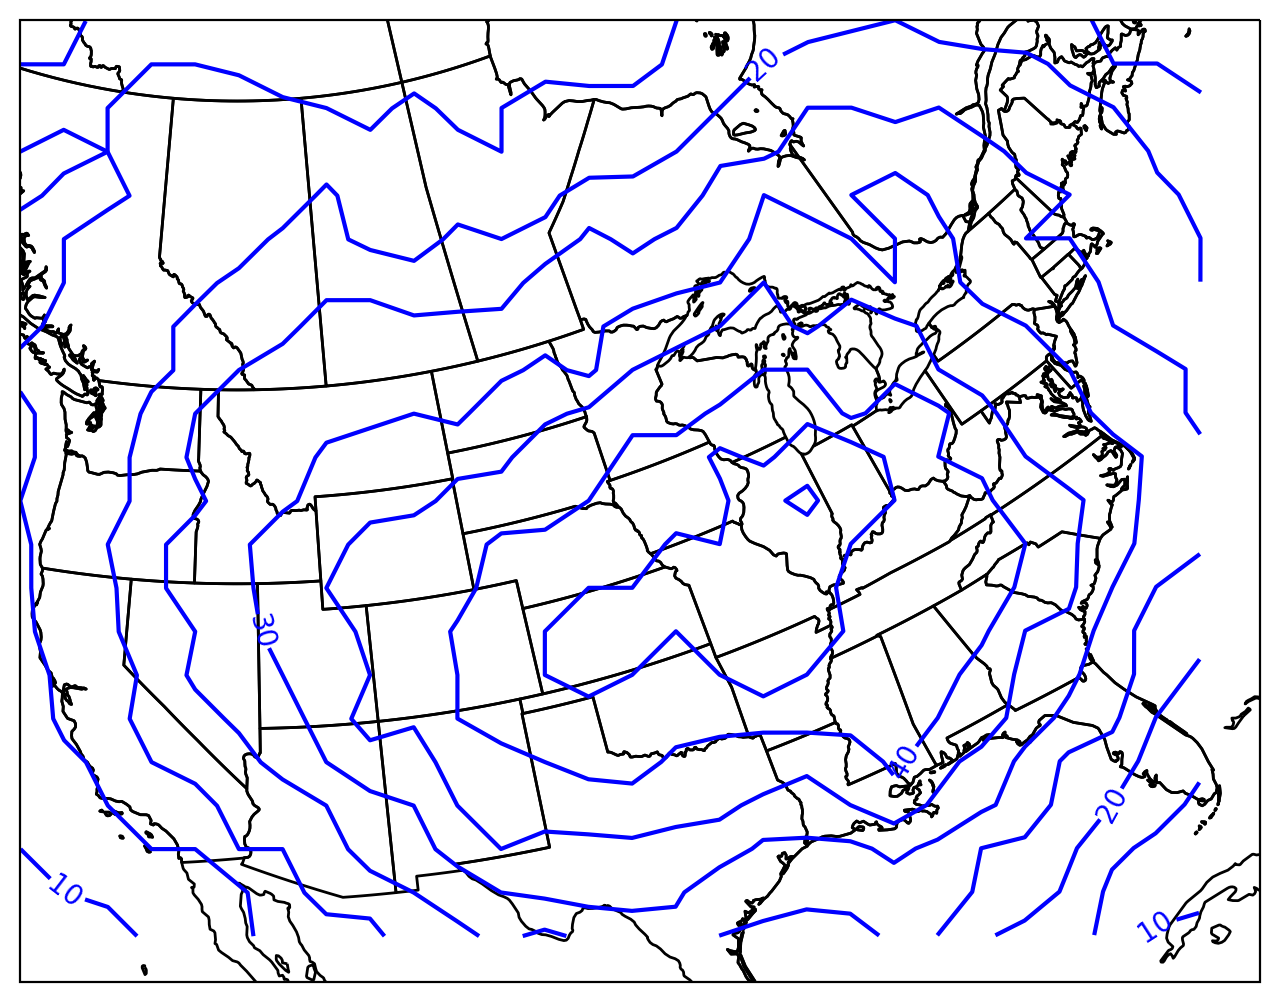

In [43]:
### Plot number of observations available to polynomial fitting scheme for each grid point ###
### using RoI = 10 cm
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot number of observations (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(lon,lat,n_observations[:,:,0],colors='b',levels=np.arange(0,200,5),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,200,10))

plt.show()

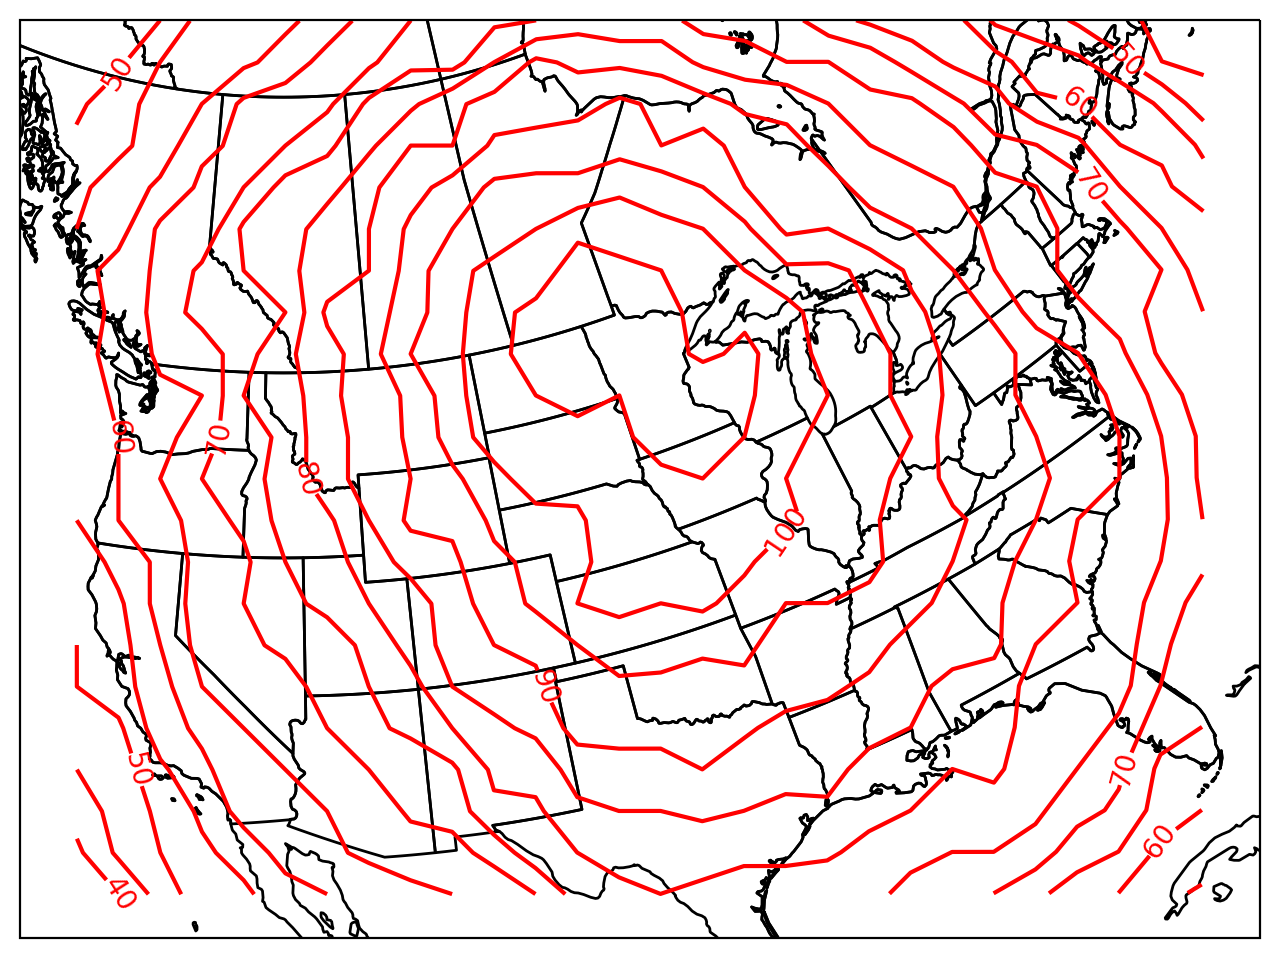

In [44]:
### Plot number of observations available to polynomial fitting scheme for each grid point ###
### using RoI = 20 cm
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot number of observations (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(lon,lat,n_observations[:,:,1],colors='r',levels=np.arange(0,200,5),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,200,10))

plt.show()

In [18]:
### Store the analyses in text files ###
np.savetxt('Analysis-Matrix_RoI-10.txt', Analysis_mat[:,:,0], delimiter=',') #Analysis Matrix RoI of 10 cm
np.savetxt('Analysis-Matrix_RoI-20.txt', Analysis_mat[:,:,1], delimiter=',') #Analysis Matrix RoI of 20 cm


In [19]:
### Store the number of observations available for each grid point in text files ###
np.savetxt('N_OBS-Matrix_RoI-10.txt', n_observations[:,:,0], delimiter=',') #N_OBS Matrix RoI of 10 cm
np.savetxt('N_OBS-Matrix_RoI-20.txt', n_observations[:,:,1], delimiter=',') #N_OBS Matrix RoI of 20 cm


In [4]:
### In a separate text file (or below), answer the following questions ###
'''
1 - Describe the general features that you see in your contoured analyses.

ANSWER: The contoured analyses using a radius of influence (RoI) of 10 cm shows a negativily tilted trough
over the midwest and southwest CONUS (4-corners of Utah, Colorado, Arizona, New Mexico). Conversely, there
is a ridge over the eastern states. Based on the positioning 5400 geopotential contour line (which is used
as the estimated freezing line/boundary) it seems that this countour map represents a day in either late
winter, early spring, or mid-fall. 

2 - Describe the differences that you see in your contoured analyses.  
    Does one analysis seem to be smoother than the other?  If so, what would cause this?

ANSWER: In the RoI=10 cm contour map the contour lines seem more close together than the RoI=20 cm contour
map. Also, In the RoI=20 cm contour map, the trough to the west is not as negativily tilited and the
positioning of the 5400 - 5580 height contours are different (shifted upwards) compared to the RoI=10 cm 
contour map. It difficult to tell exactly, but it seems that the contours displayed on the RoI=20 cm 
contour map are smoother than the RoI=10 cm contour map. The difference between the plots is soley due to
the difference in radius of influence. The higher your radius of influence, the larger the area you are
using for each grid point, and the more observation points you are including. Thus, your analysis will be
more smoother than if you used a smaller RoI.
    

3 - Run your program using a radius of influence of 6 cm (do not need to show).  
    Describe the results - do they look realistic?  If there are problems, what
    do you think might be causing them?
    
ANSWER: Using an RoI=6 cm, the contour map does not look realistic mainly due to the distortion of the
contour lines mainly near the coastlines of the CONUS. The contour lines are also less smooth than the
other plots. If you have too small of an RoI, then you enhance your risk for more localized issues. You 
will have less observations within the RoI and some observations could be bad which will effect that grid 
point value much more than if you had a higher number of observations by increasing your radius of influence.
    

4 - Suppose you ran this program with a small enough radius of influence that only one
    observation was available for determining a polynomial fit at a grid point.  Should
    you be able to perform the matrix inversion?  Why or why not?

ANSWER: No, you should not be able to perform the matrix inversion. This is because it would lead to a
singluar matrix which has a determinent equal to zero. And a matrix that has a determinant equal to zero
does NOT have a multiplicative inverse.

'''

'\n1 - Describe the general features that you see in your contoured analyses.\n    \n\n2 - Describe the differences that you see in your contoured analyses.  \n    Does one analysis seem to be smoother than the other?  If so, what would cause this?\n    \n\n3 - Run your program using a radius of influence of 6 cm (do not need to show).  \n    Describe the results - do they look realistic?  If there are problems, what\n    do you think might be causing them?\n    \n\n4 - Suppose you ran this program with a small enough radius of influence that only one\n    observation was available for determining a polynomial fit at a grid point.  Should\n    you be able to perform the matrix inversion?  Why or why not?\n\nANSWER: No, you should not be able to perform the matrix inversion. WHY? idk\n\n'